# **IMDb Movie Review Sentiment Classification using BERT**

 This project aims to classify IMDb movie reviews as positive or negative using a BERT-based model. The process involves pre-processing the text data (removing special characters, converting text to lowercase, and removing stopwords), encoding the data using the BERT tokenizer, and training a custom model on a labeled dataset. The model is fine-tuned for sequence classification and evaluated using metrics like accuracy and F1 score on the validation set. Finally, the trained model is used to make predictions on the test set, with the predicted labels added to the dataset for further analysis. The project demonstrates the power of BERT for sentiment analysis on textual data.


# **Why BERT?**

BERT is widely used in NLP tasks because of its deep understanding of context in a sentence. Unlike traditional models like bag-of-words or TF-IDF, BERT uses a transformer architecture that allows it to consider both left and right context simultaneously, making it better at understanding the nuanced meaning of words in a sentence. This contextual understanding makes BERT highly effective for sentiment analysis and text classification tasks.

# **Load the data**

In [1]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Set the new directory path
new_directory = '/content/drive/My Drive/Machine Learning/BERT'

# Change the current working directory
os.chdir(new_directory)

# Verify the change
print(f"Current directory is: {os.getcwd()}")

Mounted at /content/drive
Current directory is: /content/drive/My Drive/Machine Learning/BERT


In [5]:
import pandas as pd

# Replace 'Train_Tagged_Titles.tsv' with the correct path to your file
train_df = pd.read_csv('/content/drive/My Drive/Machine Learning/BERT/imdb dataset/Train.csv')


# Optionally, preview the first few rows
print(train_df.head())

                                                text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1


(40000, 2)


In [11]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB
None


In [6]:
import pandas as pd

# Replace 'Train_Tagged_Titles.tsv' with the correct path to your file
valid_df = pd.read_csv('/content/drive/My Drive/Machine Learning/BERT/imdb dataset/Valid.csv')


# Optionally, preview the first few rows
print(valid_df.head())

                                                text  label
0  It's been about 14 years since Sharon Stone aw...      0
1  someone needed to make a car payment... this i...      0
2  The Guidelines state that a comment must conta...      0
3  This movie is a muddled mish-mash of clichés f...      0
4  Before Stan Laurel became the smaller half of ...      0


In [8]:
print(valid_df.shape)

(5000, 2)


In [ ]:
print(train_df.info())

In [9]:
import pandas as pd

# Replace 'Train_Tagged_Titles.tsv' with the correct path to your file
test_df = pd.read_csv('/content/drive/My Drive/Machine Learning/BERT/imdb dataset/Test.csv')


# Optionally, preview the first few rows
print(test_df.head())

                                                text  label
0  I always wrote this series off as being a comp...      0
1  1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...      0
2  This movie was so poorly written and directed ...      0
3  The most interesting thing about Miryang (Secr...      1
4  when i first read about "berlin am meer" i did...      0


In [10]:
print(test_df.shape)

(5000, 2)


# **Explore the data**

In [12]:
print("Train Data:")
print(train_df.info())
print("\nValidation Data:")
print(valid_df.info())
print("\nTest Data:")
print(test_df.info())

Train Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB
None

Validation Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   label   5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.3+ KB
None

Test Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   label   5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.3+ KB
None


In [16]:
print("Train Data:")
print(train_df['label'].value_counts())
print("\nValidation Data:")
print(valid_df['label'].value_counts())
print("\nTest Data:")
print(test_df['label'].value_counts())

Train Data:
label
0    20019
1    19981
Name: count, dtype: int64

Validation Data:
label
1    2514
0    2486
Name: count, dtype: int64

Test Data:
label
1    2505
0    2495
Name: count, dtype: int64


# **Import required libraries**

In [17]:
import transformers
from transformers import get_linear_schedule_with_warmup
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import AdamW


import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import pandas as pd
import re
import string
import operator
import numpy as np
import random

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

In [18]:
print(transformers.__version__)
seed = 38
device = torch.device('cuda')
print('\n')
print(device)

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

4.47.1


cuda


# **Text Pre-Processing**

In [19]:
# Import necessary libraries and download stopwords from NLTK
from nltk.corpus import stopwords
import nltk

# Download stopwords from NLTK
nltk.download('stopwords')

# Define stopwords in English
stop = stopwords.words('english')

# Load BERT tokenizer (uncased version)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


# Text Pre-processing: Lowercasing, removing special characters, and removing stopwords
# Pre-process the 'text' column in validation dataset
valid_df['pre_text'] = valid_df['text'].str.lower()  # Convert text to lowercase
valid_df['pre_text'] = valid_df['pre_text'].str.replace(r'[^\w\s]+', '')  # Remove special characters
valid_df['pre_text'] = valid_df['pre_text'].str.replace('<br />','')  # Remove <br /> tags
valid_df['pre_text'] = valid_df['pre_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))  # Remove stopwords

# Pre-process the 'text' column in training dataset
train_df['pre_text'] = train_df['text'].str.lower()  # Convert text to lowercase
train_df['pre_text'] = train_df['pre_text'].str.replace(r'[^\w\s]+', '')  # Remove special characters
train_df['pre_text'] = train_df['pre_text'].str.replace('<br />','')  # Remove <br /> tags
train_df['pre_text'] = train_df['pre_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))  # Remove stopwords

print('Text Pre-Processing Complete!')

# Now update the original 'text' column with the cleaned 'pre_text'
valid_df['text'] = valid_df['pre_text']
train_df['text'] = train_df['pre_text']

# Print the updated shape of the datasets after pre-processing
print(train_df.shape, test_df.shape, valid_df.shape)

# Get the content (text) and labels (target values) from the training dataset
content = train_df['text'].values   # List of pre-processed text (features)
labels = train_df['label'].values   # Corresponding labels (targets)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Text Pre-Processing Complete!
(40000, 3) (5000, 2) (5000, 3)


# **Encode the Input Token**

In [20]:
def encoding_process(_content):
    get_ids = []  # List to store the tokenized input IDs

    # Loop through each text in the content list
    for text in _content:
        # Tokenize the text using the tokenizer
        input_ids = tokenizer.encode(
                        text,                      # Input text
                        add_special_tokens=True,    # Add special tokens [CLS] and [SEP]
                        max_length=256,            # Set max length to 256 tokens
                        pad_to_max_length=True,    # Pad the sequence to the max length
                        return_tensors='pt'        # Return tensor format (PyTorch tensor)
                    )
        get_ids.append(input_ids)  # Append the tokenized input IDs to the list

    # Concatenate all the tokenized inputs into one tensor
    get_ids = torch.cat(get_ids, dim=0)

    return get_ids  # Return the tensor of tokenized text


In [21]:
# make sure return_dict is not default
return_dict = False

# Training dataset
train_content = train_df['text'].values
train_labels = train_df['label'].values
train_ids = encoding_process(train_content)
train_labels = torch.tensor(train_labels)

# Validation dataset
val_content = valid_df['text'].values
val_labels = valid_df['label'].values
val_ids = encoding_process(val_content)
val_labels = torch.tensor(val_labels)

# Check the shapes of your datasets
print("Training data shape:", train_ids.shape)
print("Validation data shape:", val_ids.shape)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training data shape: torch.Size([40000, 256])
Validation data shape: torch.Size([5000, 256])


# **Model Building**

In [22]:
from torch.utils.data import DataLoader, Dataset  # Import necessary PyTorch classes
from sklearn.metrics import accuracy_score, f1_score  # Import evaluation metrics

# Define a Custom Dataset for DataLoader
class CustomDataset(Dataset):
    # This class is used to convert your input data into a format that can be fed into the DataLoader
    def __init__(self, ids, labels):
        self.ids = ids  # Store token IDs (encoded text)
        self.labels = labels  # Store labels (sentiment or classification labels)

    def __len__(self):
        # This method returns the length of the dataset
        return len(self.ids)

    def __getitem__(self, idx):
        # This method is used to access an individual item in the dataset by its index
        return {
            'input_ids': self.ids[idx],  # Return tokenized input text (input_ids)
            'labels': self.labels[idx]   # Return the corresponding label
        }

# Create the training and validation datasets using CustomDataset
train_dataset = CustomDataset(train_ids, train_labels)  # Train dataset using token IDs and labels
val_dataset = CustomDataset(val_ids, val_labels)  # Validation dataset using token IDs and labels

# Create DataLoader for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # For training, shuffle data
val_dataloader = DataLoader(val_dataset, batch_size=8)  # For validation, no need to shuffle

# Model Initialization
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2, output_attentions=False, output_hidden_states=False)
model.cuda()  # Move the model to GPU if available

# Optimizer and Scheduler setup
optimizer = AdamW(model.parameters(), lr=2e-5)  # AdamW optimizer with a learning rate of 2e-5
output_model = '/content/drive/My Drive/Machine Learning/BERT/imdb_bert_sentiment.pth'  # Path to save the trained model

# Calculate the total training steps (number of batches * number of epochs)
total_steps = len(train_dataloader) * 4  # Example for 4 epochs

# Learning rate scheduler to adjust the learning rate during training
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Save Function: Save the model and optimizer state to a file
def save(model, optimizer):
    torch.save({
        'model_state_dict': model.state_dict(),  # Save model weights
        'optimizer_state_dict': optimizer.state_dict()  # Save optimizer state
    }, output_model)

# Accuracy Calculation Function: Compute accuracy based on predictions and true labels
def accuracy_calc(preds, labels):
    pre = np.argmax(preds, axis=1).flatten()  # Get the predicted class (maximum probability)
    real = labels.flatten()  # Flatten the true labels
    return accuracy_score(real, pre)  # Return accuracy score

# F1 Score Calculation Function: Compute F1 score based on predictions and true labels
def f1_accuracy(preds, labels):
    pre = np.argmax(preds, axis=1).flatten()  # Get the predicted class
    real = labels.flatten()  # Flatten the true labels
    return f1_score(real, pre)  # Return F1 score


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# **Model Training**

In [25]:
# Training loop
epochs = 4  # Number of training epochs
for epoch in range(epochs):
    model.train()  # Set model to training mode
    total_loss, total_val_loss = 0, 0  # Initialize variables to store losses
    total_eval_accuracy = 0  # Variable to track accuracy
    _f1 = 0  # Variable to track F1 score on validation set
    _train_f1 = 0  # Variable to track F1 score on training set

    # Iterate through the training batches
    for step, batch in enumerate(train_dataloader):
        model.zero_grad()  # Clear previous gradients

        # Access 'input_ids' and 'labels' from the batch
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        # Perform a forward pass through the model, get the loss and predictions
        loss, tval_ = model(input_ids,
                            token_type_ids=None,
                            attention_mask=(input_ids > 0).to(device),
                            labels=labels,
                            return_dict=False)

        total_loss += loss.item()  # Accumulate loss for this batch
        loss.backward()  # Backpropagate gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Clip gradients to avoid explosion
        optimizer.step()  # Update the model parameters
        scheduler.step()  # Adjust learning rate based on scheduler

        tval_ = tval_.detach().cpu().numpy()  # Detach predictions from the computation graph and move to CPU
        label_ids = labels.to('cpu').numpy()  # Get true labels and move to CPU
        _train_f1 += f1_accuracy(tval_, label_ids)  # Calculate F1 score for training batch

    # Set the model to evaluation mode for validation phase
    model.eval()
    # Iterate through the validation batches
    for i, batch in enumerate(val_dataloader):
        with torch.no_grad():  # No gradients needed during evaluation
            # Access 'input_ids' and 'labels' from the batch
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            # Perform a forward pass through the model, get the loss and predictions for validation data
            loss, val_ = model(input_ids,
                               token_type_ids=None,
                               attention_mask=(input_ids > 0).to(device),
                               labels=labels,
                               return_dict=False)

            total_val_loss += loss.item()  # Accumulate validation loss

            val_ = val_.detach().cpu().numpy()  # Detach predictions from the computation graph and move to CPU
            label_ids = labels.to('cpu').numpy()  # Get true labels and move to CPU
            total_eval_accuracy += accuracy_calc(val_, label_ids)  # Calculate accuracy for validation batch
            _f1 += f1_accuracy(val_, label_ids)  # Calculate F1 score for validation batch

    # Calculate average training and validation metrics
    training_loss = total_loss / len(train_dataloader)  # Average training loss
    valid_loss = total_val_loss / len(val_dataloader)  # Average validation loss
    _accuracy = total_eval_accuracy / len(val_dataloader)  # Average validation accuracy
    _f1_score = _f1 / len(val_dataloader)  # Average F1 score on validation
    train_f1_score = _train_f1 / len(train_dataloader)  # Average F1 score on training

    # Print the performance metrics for this epoch
    print('Training loss is', training_loss)
    print('Valid loss is:', valid_loss)
    print('Acc score is:', _accuracy)
    print('F1_score is:', _f1_score)
    print('train_F1_score is:', train_f1_score)
    print('\n')

# Save the trained model and optimizer states
save(model, optimizer)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metr

Training loss is 0.321456301996205
Valid loss is: 0.2554686725292355
Acc score is: 0.908
F1_score is: 0.8942777933177951
train_F1_score is: 0.866489378399375




/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metr

Training loss is 0.19852951962067747
Valid loss is: 0.33713695072969424
Acc score is: 0.9166
F1_score is: 0.9061821911421921
train_F1_score is: 0.9380825274725249




/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metr

Training loss is 0.09684964897141908
Valid loss is: 0.43886762203676627
Acc score is: 0.9168
F1_score is: 0.9087165900765909
train_F1_score is: 0.9726928904428892




/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metr

Training loss is 0.04195311268321238
Valid loss is: 0.527080191679392
Acc score is: 0.9156
F1_score is: 0.9047214652014666
train_F1_score is: 0.9882825441225441




# **Inference**

In [26]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification

# Load the pre-trained model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.load_state_dict(torch.load('/content/drive/My Drive/Machine Learning/BERT/imdb_bert_sentiment.pth')['model_state_dict'])
model.cuda()  # Move the model to GPU if available
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Text Pre-processing (apply the same pre-processing as for the training and validation set)
test_df['pre_text'] = test_df['text'].str.lower()  # Convert text to lowercase
test_df['pre_text'] = test_df['pre_text'].str.replace(r'[^\w\s]+', '')  # Remove special characters
test_df['pre_text'] = test_df['pre_text'].str.replace('<br />', '')  # Remove <br /> tags
test_df['pre_text'] = test_df['pre_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))  # Remove stopwords

# Encode the test data
def encode_test_data(_content):
    get_ids = []  # List to store the tokenized input IDs
    for text in _content:
        input_ids = tokenizer.encode(
                        text,
                        add_special_tokens=True,  # Add special tokens [CLS] and [SEP]
                        max_length=256,  # Set max length to 256 tokens
                        pad_to_max_length=True,  # Pad the sequence to the max length
                        return_tensors='pt'  # Return tensor format (PyTorch tensor)
                    )
        get_ids.append(input_ids)  # Append the tokenized input IDs to the list
    return torch.cat(get_ids, dim=0)  # Concatenate all the tokenized inputs into one tensor

test_content = test_df['pre_text'].values  # List of pre-processed text (features)
test_ids = encode_test_data(test_content)  # Encode the test data
test_dataset = CustomDataset(test_ids, torch.zeros(test_ids.shape[0]))  # Dummy labels, we won't use them during inference
test_dataloader = DataLoader(test_dataset, batch_size=8)  # DataLoader for the test set

# Inference and prediction
model.eval()  # Set model to evaluation mode
predictions = []  # List to store predictions
with torch.no_grad():  # No gradients needed during evaluation
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)

        # Perform forward pass
        outputs = model(input_ids, token_type_ids=None, attention_mask=(input_ids > 0).to(device))
        logits = outputs[0]  # The model's output logits

        # Get predicted labels (class with maximum probability)
        preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
        predictions.extend(preds)

# Add predicted labels to test dataframe
test_df['predicted_label'] = predictions

# Calculate accuracy and F1 score for the test set
# Since you don't have ground truth labels for the test set, you'll need to manually include those, or you'll get metrics based on predictions only.
# Assuming 'label' is the column with ground truth labels in your test set (if available)
if 'label' in test_df.columns:
    test_labels = test_df['label'].values  # Actual labels for test set
    accuracy = accuracy_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score: {f1:.4f}")

# Save the updated dataframe with predictions
test_df.to_csv('/content/drive/My Drive/Machine Learning/BERT/test_predictions.csv', index=False)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-26-693a0342e2fa>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We reco

Test Accuracy: 0.9226
Test F1 Score: 0.9235


# **Evaluation on Test set**

Accuracy: 0.9226
Precision: 0.9146
Recall: 0.9325
F1 Score: 0.9235


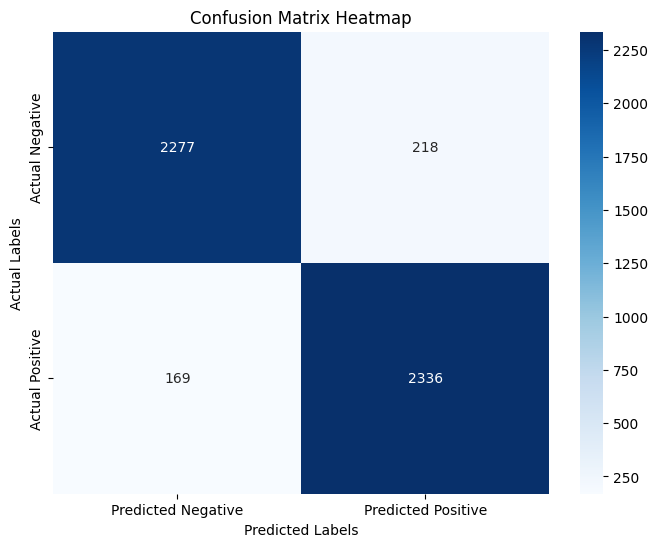

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Step 1: Load the CSV file
df = pd.read_csv('/content/drive/My Drive/Machine Learning/BERT/test_predictions.csv')
# Step 2: Extract the 'label' and 'predicted_label' columns
labels = df['label']
predicted_labels = df['predicted_label']

# Step 3: Compute the Confusion Matrix
conf_matrix = confusion_matrix(labels, predicted_labels)

# Step 4: Compute Accuracy, Precision, Recall, and F1 Score
accuracy = accuracy_score(labels, predicted_labels)
precision = precision_score(labels, predicted_labels, average='binary')  # Use 'micro', 'macro' for multi-class
recall = recall_score(labels, predicted_labels, average='binary')  # Use 'micro', 'macro' for multi-class
f1 = f1_score(labels, predicted_labels, average='binary')  # Use 'micro', 'macro' for multi-class

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Step 5: Plot the Confusion Matrix as a Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix Heatmap')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()